<a href="https://colab.research.google.com/github/flohmannjr/tensorflow_curso/blob/main/Cota%C3%A7%C3%A3o_do_Milho.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cotação do Milho, NY Futuros, 01.02.2013 a 31.01.2023

Fonte: Investing.com - https://br.investing.com/commodities/us-corn

Tipo: Commodities - Grupo: Agrícola - Unidade: 1 Celemim

# Importações

In [1]:
import tensorflow as tf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import absl.logging, os

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

from tensorflow.data import AUTOTUNE, Dataset
from tensorflow.keras import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Add, Bidirectional, Conv1D, Dense, GRU, Input, Lambda, Layer, LSTM, Subtract
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

# Configurações

In [2]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100

plt.style.use('seaborn-darkgrid')

absl.logging.set_verbosity(absl.logging.ERROR)  # Apresentar apenas erros.

## Constantes

In [3]:
SEMENTE = 2008193

COR_TREINO   = '#663399'
COR_PREVISAO = '#f22424'
COR_TESTE    = '#345cd3'

LINHA_ESPESSURA = 1

TAMANHO_CNN = 128

ATIVACAO_CNN = 'relu'
ATIVACAO_HORIZONTE = 'linear'
ATIVACAO_RNN = 'tanh'

PERDA = 'mae'
METRICAS = ['mae', 'mse']

ITERACOES = 100
TAMANHO_LOTE = 128
CAMINHO_MARCOS = 'marcos'

FILTROS = 128
TAMANHO_NUCLEO = 5
PREENCHIMENTO = 'causal'

UNIDADES = 128

TAMANHO_LOTE_DATASET = 256

INICIALIZADOR = 'he_normal'

## Funções

In [4]:
!wget https://raw.githubusercontent.com/flohmannjr/tensorflow_curso/main/funcoes_temporais.py

--2023-02-12 02:19:01--  https://raw.githubusercontent.com/flohmannjr/tensorflow_curso/main/funcoes_temporais.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4157 (4.1K) [text/plain]
Saving to: ‘funcoes_temporais.py’

funcoes_temporais.p 100%[===================>]   4.06K  --.-KB/s    in 0s      

2023-02-12 02:19:01 (45.5 MB/s) - ‘funcoes_temporais.py’ saved [4157/4157]



In [5]:
from funcoes_temporais import grafico_series, grafico_metrica, mean_absolute_scaled_error, metricas_modelo, criar_janelas, separar_janelas_treino_teste, criar_marco_modelo

In [6]:
def obter_modelos(horizonte,
                  dados_treino,
                  dados_teste,
                  modelos_por_perda=10,
                  iteracoes=1000,
                  funcoes_perda=['mae', 'mse', 'mape']):

    conjunto_modelos = []

    for m in range(modelos_por_perda):

        for perda in funcoes_perda:

            modelo_nome = f'conjunto_modelo_{m}_perda_{perda}'

            print(f"Treinando modelo {modelo_nome} com {iteracoes} iterações.")

            modelo = Sequential(name=modelo_nome)

            for c in range(4):
                modelo.add(Dense(units=TAMANHO_CNN, kernel_initializer=INICIALIZADOR, activation=ATIVACAO_CNN, name=f'camada_relu_{c}'))

            modelo.add(Dense(units=horizonte, activation=ATIVACAO_HORIZONTE, name='camada_saida'))

            modelo.compile(loss=perda,
                           optimizer=Adam(),
                           metrics=METRICAS)
            
            modelo.fit(dados_treino,
                       epochs=iteracoes,
                       validation_data=dados_teste,
                       callbacks=[EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True),
                                  ReduceLROnPlateau(monitor='val_loss', patience=50)],
                       verbose=0)
            
            conjunto_modelos.append(modelo)

    return conjunto_modelos

def obter_previsoes(modelos, dados_teste):
    
    conjunto_previsoes = []

    for modelo in modelos:

        print(f'Prevendo com modelo {modelo.name}.')

        previsoes = modelo.predict(dados_teste)

        conjunto_previsoes.append(previsoes)
    
    return tf.constant(tf.squeeze(conjunto_previsoes))

# Dados

In [7]:
df = pd.read_csv('https://raw.githubusercontent.com/flohmannjr/tensorflow_curso/main/dados/milho_ny_20130201_20230131.csv',
                 parse_dates=['Data'],
                 dayfirst=True,  # 'Data' está no formato dd.mm.aaaa.
                 index_col=['Data'])

df = df.sort_index()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2549 entries, 2013-02-01 to 2023-01-31
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Último    2549 non-null   float64
 1   Abertura  2549 non-null   float64
 2   Máxima    2549 non-null   float64
 3   Mínima    2549 non-null   float64
 4   Vol.      2516 non-null   object 
 5   Var%      2549 non-null   object 
dtypes: float64(4), object(2)
memory usage: 139.4+ KB


In [9]:
df_wasde = pd.read_csv('https://raw.githubusercontent.com/flohmannjr/tensorflow_curso/main/dados/wasde_corn_avg_farm_price_est_us_201301_202301.csv',
                       parse_dates=['ReportDate'])

In [10]:
df_wasde.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   WasdeNumber    95 non-null     int64         
 1   Region         95 non-null     object        
 2   Commodity      95 non-null     object        
 3   Attribute      95 non-null     object        
 4   ProjEstFlag    95 non-null     object        
 5   ReportDate     95 non-null     datetime64[ns]
 6   MarketYear     95 non-null     object        
 7   Value          95 non-null     float64       
 8   Unit           95 non-null     object        
 9   ReleaseDate    95 non-null     object        
 10  ForecastYear   95 non-null     int64         
 11  ForecastMonth  95 non-null     int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(7)
memory usage: 9.0+ KB


## Limpeza e ajustes

In [11]:
# Renomear colunas
df = df.rename(columns={'Último': 'Fechamento', 'Vol.': 'Volume', 'Var%': 'Variação'})

# 'Preço Médio Fazenda' com valores nulos
df['Preço Médio Fazenda'] = None

# Popular 'Preço Médio Fazenda' com valores WASDE
for i in df.index:
    valor = df_wasde['Value'][df_wasde['ReportDate'].dt.strftime('%Y%m') == i.strftime('%Y%m')]

    if len(valor) > 0:
        df.loc[i, 'Preço Médio Fazenda'] = int(valor)

# Popular 'Preço Médio Fazenda' não encontrados com valor anterior
df['Preço Médio Fazenda'] = df['Preço Médio Fazenda'].fillna(method='ffill')

# Retira a letra 'K' do final dos valores e modifica para 'float'.
df['Volume'] = df['Volume'].str[:-1].astype(float)

# Substitui valores indisponíveis por 0.
df['Volume'] = df['Volume'].fillna(0)

# Multiplica por 1000 e modifica para 'int'.
df['Volume'] = (df['Volume'] * 1000).astype(int)

# Retira o símbolo '%' do final dos valores, modifica para 'float' e divide por 100.
df['Variação'] = df['Variação'].str[:-1].astype(float) / 100

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2549 entries, 2013-02-01 to 2023-01-31
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Fechamento           2549 non-null   float64
 1   Abertura             2549 non-null   float64
 2   Máxima               2549 non-null   float64
 3   Mínima               2549 non-null   float64
 4   Volume               2549 non-null   int64  
 5   Variação             2549 non-null   float64
 6   Preço Médio Fazenda  2549 non-null   int64  
dtypes: float64(5), int64(2)
memory usage: 223.9 KB


In [13]:
df.describe()

,Fechamento,Abertura,Máxima,Mínima,Volume,Variação,Preço Médio Fazenda
count,2549.000000,2549.000000,2549.000000,2549.000000,2549.000000,2549.000000,2549.000000
mean,446.056473,445.918807,450.706218,441.367187,122774.510396,0.000097,3.853668
std,123.883183,123.703861,125.930037,121.678627,84776.288079,0.016127,1.160648
min,301.500000,302.000000,307.250000,300.250000,0.000000,-0.173900,3.000000
25%,361.750000,361.500000,364.750000,358.500000,60380.000000,-0.008200,3.000000
50%,384.500000,384.500000,388.500000,380.500000,123570.000000,0.000200,3.000000
75%,512.250000,512.250000,518.250000,505.750000,174400.000000,0.008800,4.000000
max,818.250000,817.500000,827.000000,814.000000,523850.000000,0.080200,6.000000


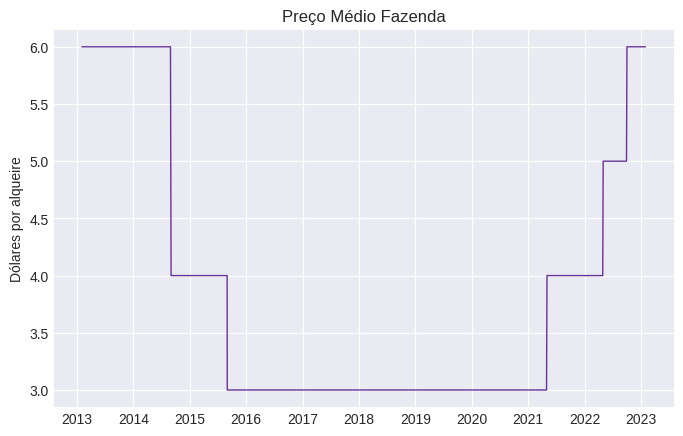

In [14]:
sns.lineplot(data=df, x='Data', y='Preço Médio Fazenda', color=COR_TREINO, linewidth=LINHA_ESPESSURA)

plt.title('Preço Médio Fazenda')
plt.xlabel('')
plt.ylabel('Dólares por alqueire');

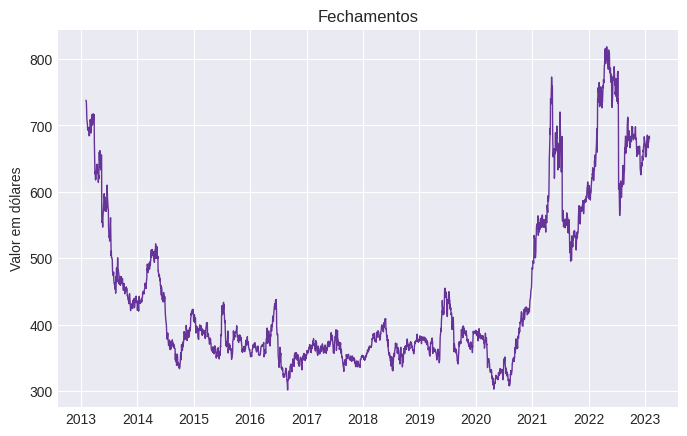

In [15]:
sns.lineplot(data=df, x='Data', y='Fechamento', color=COR_TREINO, linewidth=LINHA_ESPESSURA)

plt.title('Fechamentos')
plt.xlabel('')
plt.ylabel('Valor em dólares');

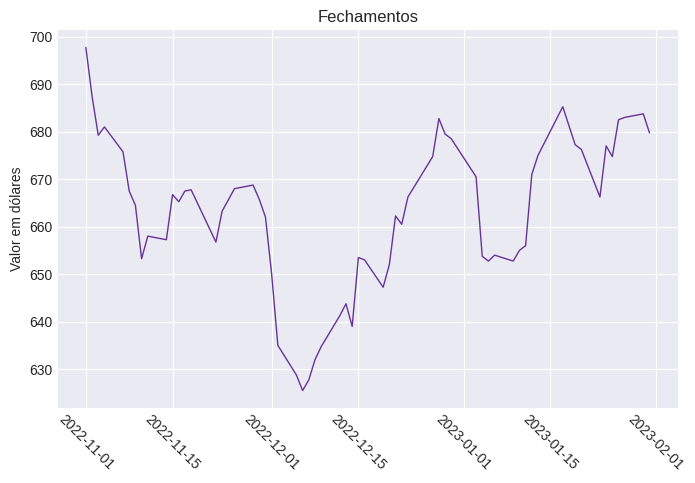

In [16]:
df_recente = df[df.index >= '2022-11-01']

sns.lineplot(data=df_recente, x='Data', y='Fechamento', color=COR_TREINO, linewidth=LINHA_ESPESSURA)

plt.title('Fechamentos')
plt.xlabel('')
plt.ylabel('Valor em dólares')

plt.xticks(rotation=-45);

## Separação treino e teste

In [17]:
treino_tamanho = int(len(df) * 0.8)  # 80% da base
treino_tamanho

2039

In [18]:
X_train = df[:treino_tamanho].index.to_numpy()
y_train = df[:treino_tamanho]['Fechamento'].to_numpy()

X_test = df[treino_tamanho:].index.to_numpy()
y_test = df[treino_tamanho:]['Fechamento'].to_numpy()

len(X_train), len(y_train), len(X_test), len(y_test)

(2039, 2039, 510, 510)

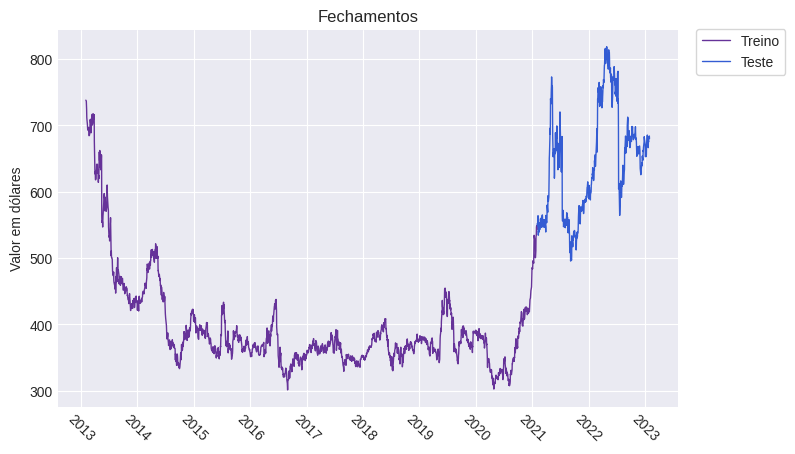

In [19]:
grafico_series(X_treino=X_train, y_treino=y_train,
               X_teste=X_test, y_teste=y_test)

# Modelos

In [20]:
metricas = [None] * 20

## Modelo 0: Naïve (Ingênuo, modelo-base.)

Naïve method: https://otexts.com/fpp3/simple-methods.html#na%C3%AFve-method

Para previsões ingênuas, simplesmente definimos todas as previsões como o valor da observação anterior.

In [21]:
y_pred = y_test[:-1]

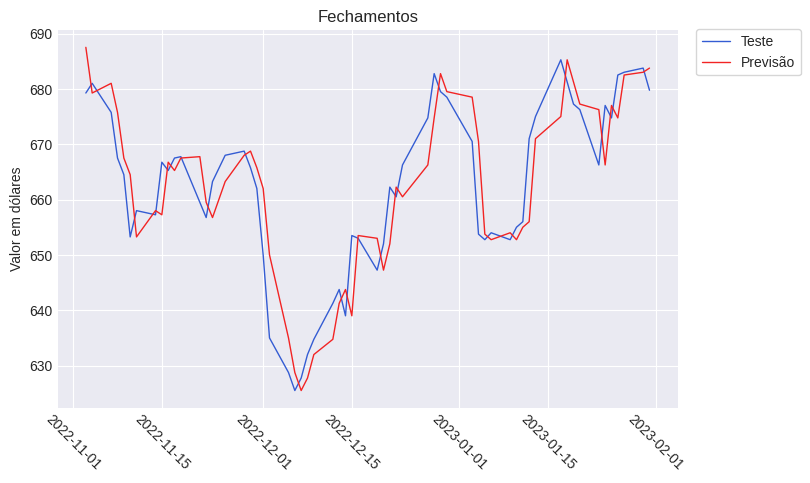

In [22]:
grafico_series(X_teste=X_test, y_teste=y_test,
               X_previsao=X_test[1:], y_previsao=y_pred,  # As previsões são as mesmas das observações anteriores, portanto o primeiro valor dos dados de teste é ignorado.
               inicio=-60)                                # Mostrando somentes os últimos 60 registros, para facilitar a visualização.

O gráfico de previsões (ingênuo) não é um perfeito deslocamento do gráfico de testes, neste caso, pois os dados não possuem valor nos finais de semana e feriados, então os registros não têm um intervalo constante.

In [23]:
metricas[0] = metricas_modelo(y_test[1:], y_pred)

## Separação dos dados em janelas e horizontes

Janela: Dados utilizados para fazer a previsão. (7 valores, neste projeto.)

Horizonte: Previsão. (1 valor, neste projeto.)

```
Janela                  Horizonte
[0, 1, 2, 3, 4, 5, 6]   [7]
[1, 2, 3, 4, 5, 6, 7]   [8]
[2, 3, 4, 5, 6, 7, 8]   [9]
```

In [24]:
dados = df['Fechamento'].to_numpy().astype('float32')
precos = df['Preço Médio Fazenda'].to_numpy().astype('float32')
janela_tamanho = 7
horizonte_tamanho = 1

# janelas, horizontes = criar_janelas(dados, janela_tamanho, horizonte_tamanho)          # janela somente com Fechamentos.
janelas, horizontes = criar_janelas(dados, janela_tamanho, horizonte_tamanho, precos)  # janela com Fechamentos e Preço Médio Fazenda.

janelas_treino, janelas_teste, horizontes_treino, horizontes_teste = separar_janelas_treino_teste(janelas, horizontes, tamanho_teste=0.2)

## Modelo 1: scikit-learn Linear Regression

In [25]:
modelo = LinearRegression()

modelo.fit(janelas_treino, horizontes_treino[:, 0])

y_pred = modelo.predict(janelas_teste)

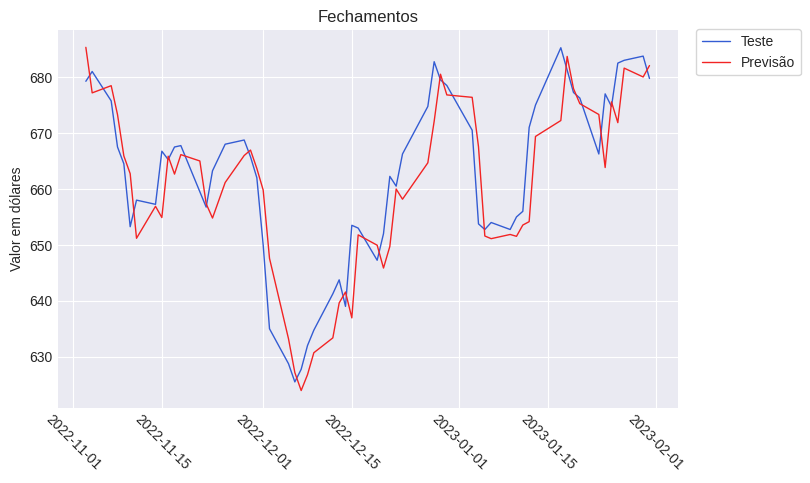

In [26]:
grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=horizontes_teste[:, 0],
               X_previsao=X_test[-len(janelas_teste):], y_previsao=y_pred,
               inicio=-60)

In [27]:
metricas[1] = metricas_modelo(horizontes_teste[:, 0], y_pred)

## Modelo 2: scikit-learn Support Vector Regression

In [28]:
modelo = SVR()

modelo.fit(janelas_treino, horizontes_treino[:, 0])

y_pred = modelo.predict(janelas_teste)

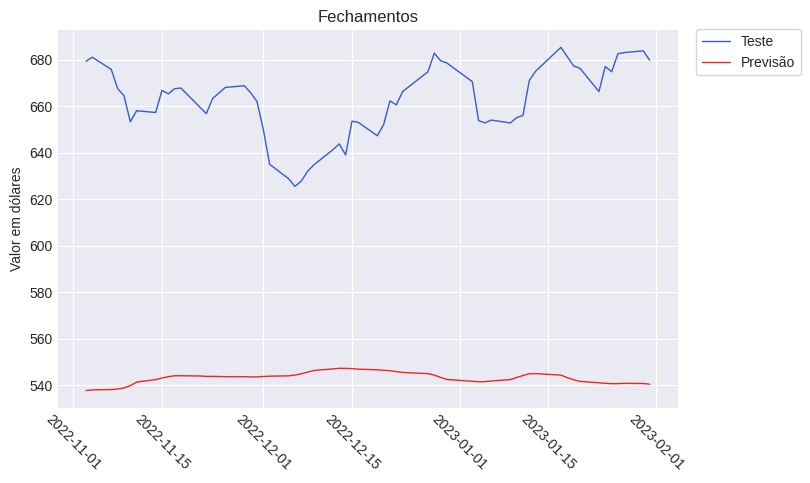

In [29]:
grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=horizontes_teste[:, 0],
               X_previsao=X_test[-len(janelas_teste):], y_previsao=y_pred,
               inicio=-60)

In [30]:
metricas[2] = metricas_modelo(horizontes_teste[:, 0], y_pred)

## Modelo 3: scikit-learn Random Forest Regression

In [31]:
modelo = RandomForestRegressor()

modelo.fit(janelas_treino, horizontes_treino[:, 0])

y_pred = modelo.predict(janelas_teste)

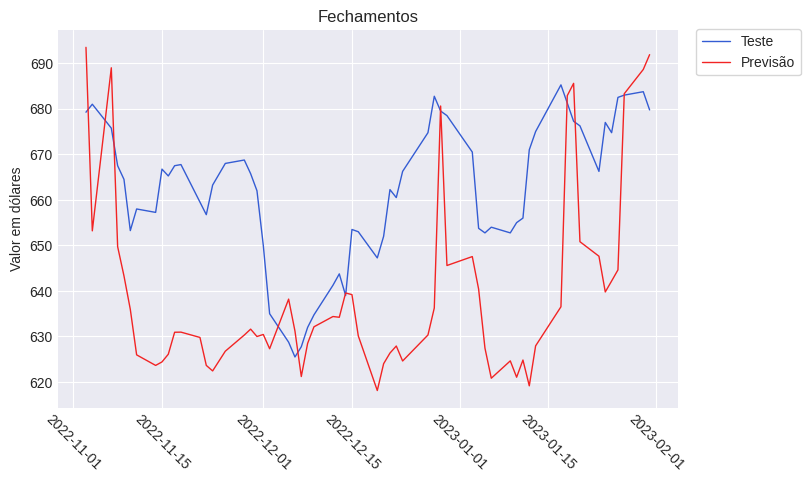

In [32]:
grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=horizontes_teste[:, 0],
               X_previsao=X_test[-len(janelas_teste):], y_previsao=y_pred,
               inicio=-60)

In [33]:
metricas[3] = metricas_modelo(horizontes_teste[:, 0], y_pred)

## Modelo 4: scikit-learn Multi-layer Perceptron Regression

In [34]:
modelo = MLPRegressor()

modelo.fit(janelas_treino, horizontes_treino[:, 0])

y_pred = modelo.predict(janelas_teste)

/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


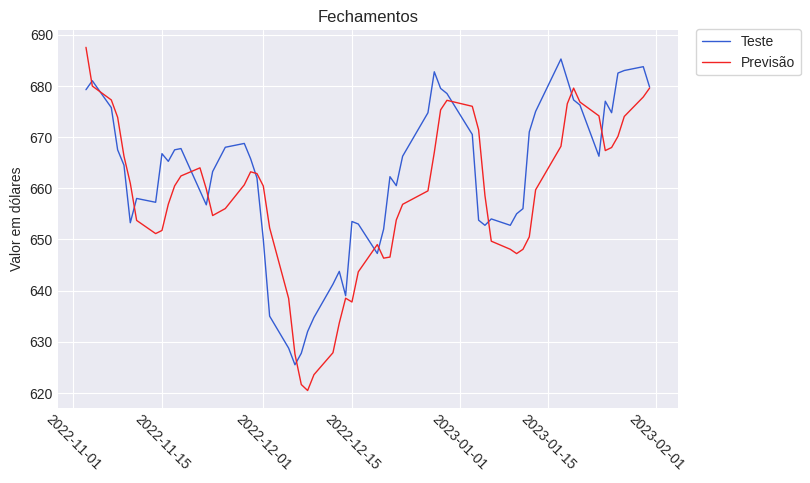

In [35]:
grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=horizontes_teste[:, 0],
               X_previsao=X_test[-len(janelas_teste):], y_previsao=y_pred,
               inicio=-60)

In [36]:
metricas[4] = metricas_modelo(horizontes_teste[:, 0], y_pred)

## Modelo 5: TensorFlow Dense

In [37]:
%%time

tf.random.set_seed(SEMENTE)

modelo_nome = 'modelo_5_denso_7j_1h'

modelo = Sequential(name=modelo_nome)

modelo.add(Dense(units=TAMANHO_CNN, activation=ATIVACAO_CNN, name='camada_relu'))
modelo.add(Dense(units=horizonte_tamanho, activation=ATIVACAO_HORIZONTE, name='camada_saida'))

modelo.compile(loss=PERDA,
               optimizer=Adam(),
               metrics=METRICAS)

historico = modelo.fit(x=janelas_treino,
                       y=horizontes_treino,
                       epochs=ITERACOES,
                       batch_size=TAMANHO_LOTE,
                       validation_data=(janelas_teste, horizontes_teste),
                       callbacks=[criar_marco_modelo(modelo_nome, caminho=CAMINHO_MARCOS)],
                       verbose=0)

CPU times: user 34.3 s, sys: 2.38 s, total: 36.7 s
Wall time: 46.3 s


In [38]:
modelo.evaluate(janelas_teste, horizontes_teste)

16/16 [==============================] - 0s 3ms/step - loss: 10.1031 - mae: 10.1031 - mse: 232.7484


[10.10307502746582, 10.10307502746582, 232.74844360351562]

In [39]:
modelo = load_model(os.path.join(CAMINHO_MARCOS, modelo_nome))
modelo.evaluate(janelas_teste, horizontes_teste)

16/16 [==============================] - 0s 2ms/step - loss: 10.1031 - mae: 10.1031 - mse: 232.7484


[10.10307502746582, 10.10307502746582, 232.74844360351562]

In [40]:
previsoes = modelo.predict(janelas_teste)

16/16 [==============================] - 0s 2ms/step


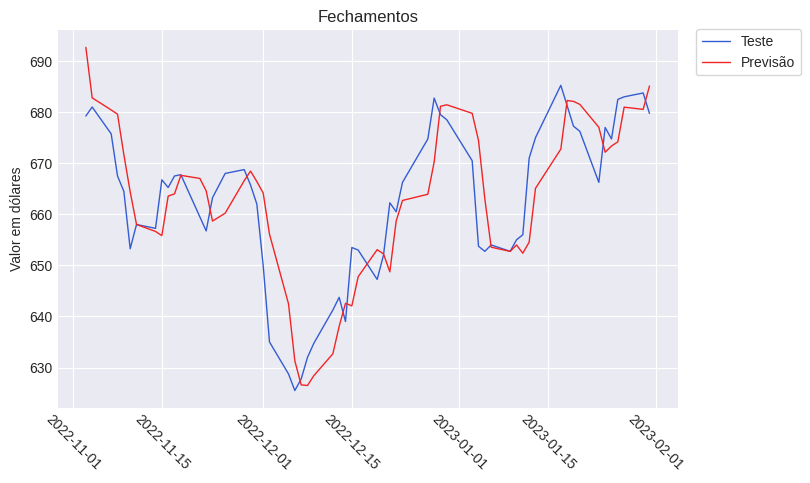

In [41]:
grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=tf.squeeze(horizontes_teste),
               X_previsao=X_test[-len(janelas_teste):], y_previsao=tf.squeeze(previsoes),
               inicio=-60)

In [42]:
metricas[5] = metricas_modelo(tf.squeeze(horizontes_teste), tf.squeeze(previsoes))

## Modelo 6: TensorFlow Convulational

In [43]:
%%time

tf.random.set_seed(SEMENTE)

modelo_nome = 'modelo_6_convulacional'

modelo = Sequential(name=modelo_nome)

modelo.add(Lambda(lambda x: tf.expand_dims(x, axis=1), name='camada_lambda'))  # Adiciona uma dimensão (input_dim) aos dados. Conv1D espera (batch_size, timesteps, input_dim).

modelo.add(Conv1D(filters=FILTROS,
                  kernel_size=TAMANHO_NUCLEO,
                  padding=PREENCHIMENTO,
                  activation=ATIVACAO_CNN,
                  name='camada_convulacional'))

modelo.add(Dense(units=horizonte_tamanho, activation=ATIVACAO_HORIZONTE, name='camada_saida'))

modelo.compile(loss=PERDA,
               optimizer=Adam(),
               metrics=METRICAS)

modelo.fit(x=janelas_treino,
           y=horizontes_treino,
           epochs=ITERACOES,
           batch_size=TAMANHO_LOTE,
           validation_data=(janelas_teste, horizontes_teste),
           callbacks=[criar_marco_modelo(modelo_nome, caminho=CAMINHO_MARCOS)],
           verbose=0)

CPU times: user 36.1 s, sys: 1.54 s, total: 37.6 s
Wall time: 41.6 s


In [44]:
modelo.evaluate(janelas_teste, horizontes_teste)

16/16 [==============================] - 0s 4ms/step - loss: 10.5568 - mae: 10.5568 - mse: 247.1556


[10.556835174560547, 10.556835174560547, 247.1555938720703]

In [45]:
modelo = load_model(os.path.join(CAMINHO_MARCOS, modelo_nome))
modelo.evaluate(janelas_teste, horizontes_teste)

16/16 [==============================] - 0s 3ms/step - loss: 10.5412 - mae: 10.5412 - mse: 255.2103


[10.541167259216309, 10.541167259216309, 255.2102813720703]

In [46]:
previsoes = modelo.predict(janelas_teste)

16/16 [==============================] - 0s 2ms/step


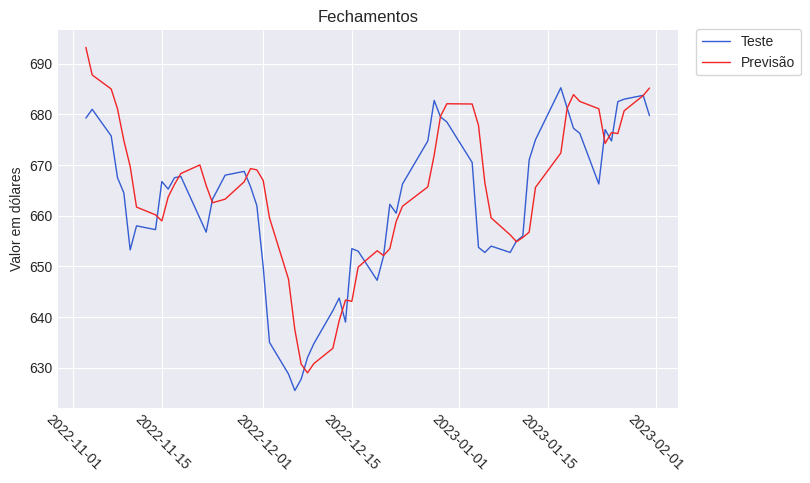

In [47]:
grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=tf.squeeze(horizontes_teste),
               X_previsao=X_test[-len(janelas_teste):], y_previsao=tf.squeeze(previsoes),
               inicio=-60)

In [48]:
metricas[6] = metricas_modelo(tf.squeeze(horizontes_teste), tf.squeeze(previsoes))

## Modelo 7: TensorFlow LSTM

In [49]:
%%time

tf.random.set_seed(SEMENTE)

modelo_nome = 'modelo_7_lstm'

modelo = Sequential(name=modelo_nome)

modelo.add(Lambda(lambda x: tf.expand_dims(x, axis=1), name='camada_lambda'))
modelo.add(LSTM(units=UNIDADES, activation=ATIVACAO_CNN, name='camada_lstm'))  # Ativação 'relu' no lugar de 'tanh' por motivo de performance.
modelo.add(Dense(units=horizonte_tamanho, activation=ATIVACAO_HORIZONTE, name='camada_saida'))

modelo.compile(loss=PERDA,
               optimizer=Adam(),
               metrics=METRICAS)

modelo.fit(x=janelas_treino,
           y=horizontes_treino,
           epochs=ITERACOES,
           batch_size=TAMANHO_LOTE,
           validation_data=(janelas_teste, horizontes_teste),
           callbacks=[criar_marco_modelo(modelo_nome, caminho=CAMINHO_MARCOS)],
           verbose=0)

CPU times: user 1min 25s, sys: 2.02 s, total: 1min 27s
Wall time: 1min 24s


In [50]:
modelo.evaluate(janelas_teste, horizontes_teste)

16/16 [==============================] - 0s 3ms/step - loss: 11.9577 - mae: 11.9577 - mse: 291.0094


[11.957662582397461, 11.957662582397461, 291.0094299316406]

In [51]:
modelo = load_model(os.path.join(CAMINHO_MARCOS, modelo_nome))
modelo.evaluate(janelas_teste, horizontes_teste)

16/16 [==============================] - 0s 3ms/step - loss: 11.1201 - mae: 11.1201 - mse: 281.5895


[11.120133399963379, 11.120133399963379, 281.58953857421875]

In [52]:
previsoes = modelo.predict(janelas_teste)

16/16 [==============================] - 0s 2ms/step


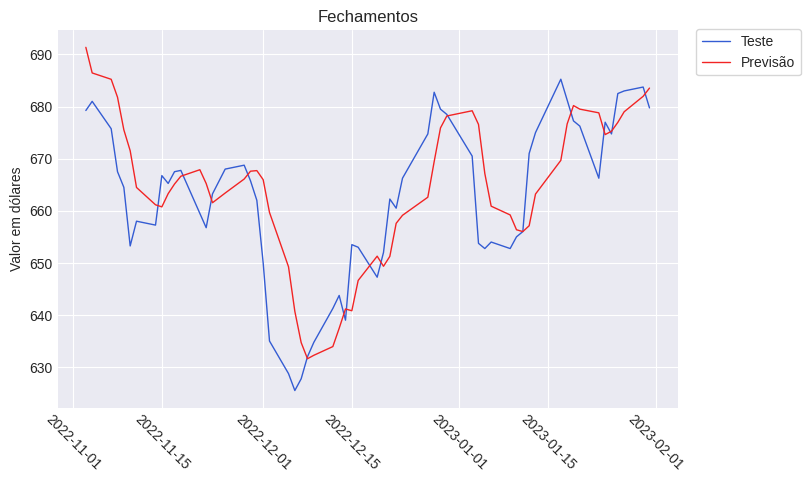

In [53]:
grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=tf.squeeze(horizontes_teste),
               X_previsao=X_test[-len(janelas_teste):], y_previsao=tf.squeeze(previsoes),
               inicio=-60)

In [54]:
metricas[7] = metricas_modelo(tf.squeeze(horizontes_teste), tf.squeeze(previsoes))

## Modelo 8: TensorFlow GRU

In [55]:
%%time

tf.random.set_seed(SEMENTE)

modelo_nome = 'modelo_8_gru'

modelo = Sequential(name=modelo_nome)

modelo.add(Lambda(lambda x: tf.expand_dims(x, axis=1), name='camada_lambda'))
modelo.add(GRU(units=UNIDADES, activation=ATIVACAO_CNN, name='camada_gru'))
modelo.add(Dense(units=horizonte_tamanho, activation=ATIVACAO_HORIZONTE, name='camada_saida'))

modelo.compile(loss=PERDA,
               optimizer=Adam(),
               metrics=METRICAS)

modelo.fit(x=janelas_treino,
           y=horizontes_treino,
           epochs=ITERACOES,
           batch_size=TAMANHO_LOTE,
           validation_data=(janelas_teste, horizontes_teste),
           callbacks=[criar_marco_modelo(modelo_nome, caminho=CAMINHO_MARCOS)],
           verbose=0)

CPU times: user 1min 31s, sys: 2.28 s, total: 1min 33s
Wall time: 1min 29s


In [56]:
modelo.evaluate(janelas_teste, horizontes_teste)

16/16 [==============================] - 0s 3ms/step - loss: 11.6348 - mae: 11.6348 - mse: 285.4904


[11.63476848602295, 11.63476848602295, 285.4903869628906]

In [57]:
modelo = load_model(os.path.join(CAMINHO_MARCOS, modelo_nome))
modelo.evaluate(janelas_teste, horizontes_teste)

16/16 [==============================] - 0s 5ms/step - loss: 11.3090 - mae: 11.3090 - mse: 293.2053


[11.309045791625977, 11.309045791625977, 293.2052917480469]

In [58]:
previsoes = modelo.predict(janelas_teste)

16/16 [==============================] - 0s 3ms/step


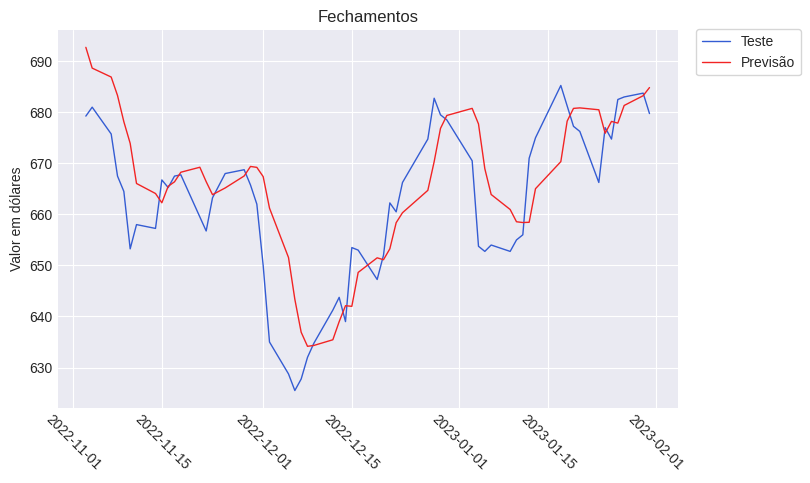

In [59]:
grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=tf.squeeze(horizontes_teste),
               X_previsao=X_test[-len(janelas_teste):], y_previsao=tf.squeeze(previsoes),
               inicio=-60)

In [60]:
metricas[8] = metricas_modelo(tf.squeeze(horizontes_teste), tf.squeeze(previsoes))

## Modelo 9: TensorFlow Bidirectional LSTM

In [61]:
%%time

tf.random.set_seed(SEMENTE)

modelo_nome = 'modelo_9_bi_lstm'

modelo = Sequential(name=modelo_nome)

modelo.add(Lambda(lambda x: tf.expand_dims(x, axis=1), name='camada_lambda'))
modelo.add(Bidirectional(layer=LSTM(units=UNIDADES, activation=ATIVACAO_CNN), name='camada_bi_lstm'))
modelo.add(Dense(units=horizonte_tamanho, activation=ATIVACAO_HORIZONTE, name='camada_saida'))

modelo.compile(loss=PERDA,
               optimizer=Adam(),
               metrics=METRICAS)

modelo.fit(x=janelas_treino,
           y=horizontes_treino,
           epochs=ITERACOES,
           batch_size=TAMANHO_LOTE,
           validation_data=(janelas_teste, horizontes_teste),
           callbacks=[criar_marco_modelo(modelo_nome, caminho=CAMINHO_MARCOS)],
           verbose=0)

CPU times: user 3min 17s, sys: 3.47 s, total: 3min 21s
Wall time: 3min 14s


In [62]:
modelo.evaluate(janelas_teste, horizontes_teste)

16/16 [==============================] - 0s 3ms/step - loss: 12.2916 - mae: 12.2916 - mse: 331.6071


[12.291610717773438, 12.291610717773438, 331.6071472167969]

In [63]:
modelo = load_model(os.path.join(CAMINHO_MARCOS, modelo_nome))
modelo.evaluate(janelas_teste, horizontes_teste)

16/16 [==============================] - 0s 3ms/step - loss: 12.2678 - mae: 12.2678 - mse: 336.8717


[12.267807960510254, 12.267807960510254, 336.8717041015625]

In [64]:
previsoes = modelo.predict(janelas_teste)

16/16 [==============================] - 0s 2ms/step


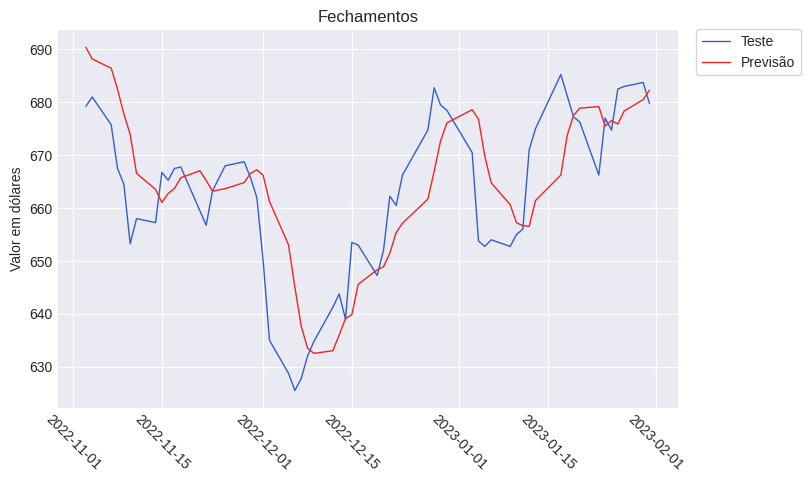

In [65]:
grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=tf.squeeze(horizontes_teste),
               X_previsao=X_test[-len(janelas_teste):], y_previsao=tf.squeeze(previsoes),
               inicio=-60)

In [66]:
metricas[9] = metricas_modelo(tf.squeeze(horizontes_teste), tf.squeeze(previsoes))

## Modelo 10: TensorFlow Deeper Dense

In [67]:
%%time

tf.random.set_seed(SEMENTE)

modelo_nome = 'modelo_10_denso_profundo'

modelo = Sequential(name=modelo_nome)

for c in range(4):
    modelo.add(Dense(units=TAMANHO_CNN, activation=ATIVACAO_CNN, name=f'camada_relu_{c}'))

modelo.add(Dense(units=horizonte_tamanho, activation=ATIVACAO_HORIZONTE, name='camada_saida'))

modelo.compile(loss=PERDA,
               optimizer=Adam(),
               metrics=METRICAS)

historico = modelo.fit(x=janelas_treino,
                       y=horizontes_treino,
                       epochs=ITERACOES,
                       batch_size=TAMANHO_LOTE,
                       validation_data=(janelas_teste, horizontes_teste),
                       callbacks=[criar_marco_modelo(modelo_nome, caminho=CAMINHO_MARCOS)],
                       verbose=0)

CPU times: user 34.2 s, sys: 953 ms, total: 35.2 s
Wall time: 41.9 s


In [68]:
modelo.evaluate(janelas_teste, horizontes_teste)

16/16 [==============================] - 0s 2ms/step - loss: 9.4487 - mae: 9.4487 - mse: 210.5286


[9.448686599731445, 9.448686599731445, 210.52859497070312]

In [69]:
modelo = load_model(os.path.join(CAMINHO_MARCOS, modelo_nome))
modelo.evaluate(janelas_teste, horizontes_teste)

16/16 [==============================] - 0s 3ms/step - loss: 9.4487 - mae: 9.4487 - mse: 210.5286


[9.448686599731445, 9.448686599731445, 210.52859497070312]

In [70]:
previsoes = modelo.predict(janelas_teste)

16/16 [==============================] - 0s 2ms/step


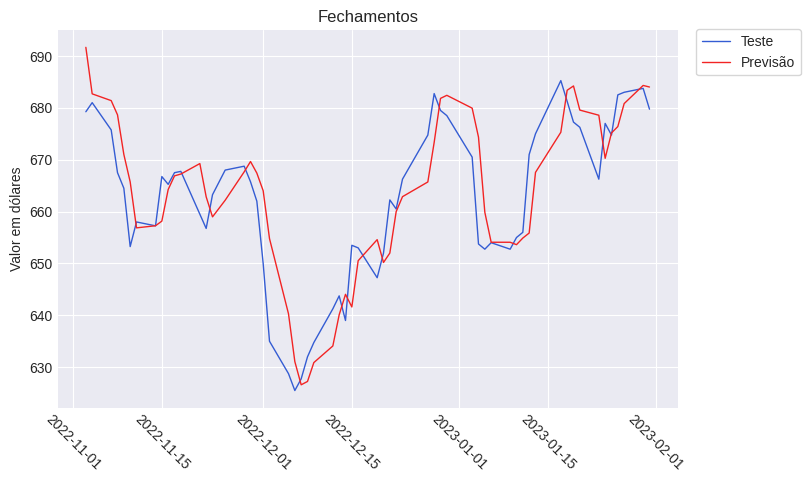

In [71]:
grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=tf.squeeze(horizontes_teste),
               X_previsao=X_test[-len(janelas_teste):], y_previsao=tf.squeeze(previsoes),
               inicio=-60)

In [72]:
metricas[10] = metricas_modelo(tf.squeeze(horizontes_teste), tf.squeeze(previsoes))

## Modelo 11: TensorFlow N-BEATS

In [73]:
dados = df['Fechamento'].to_numpy().astype('float32')
janela_tamanho = 7
horizonte_tamanho = 1

janelas, horizontes = criar_janelas(dados, janela_tamanho, horizonte_tamanho)

janelas_treino, janelas_teste, horizontes_treino, horizontes_teste = separar_janelas_treino_teste(janelas, horizontes, tamanho_teste=0.2)

In [74]:
dataset_janelas_treino    = Dataset.from_tensor_slices(janelas_treino)
dataset_janelas_teste     = Dataset.from_tensor_slices(janelas_teste)
dataset_horizontes_treino = Dataset.from_tensor_slices(horizontes_treino)
dataset_horizontes_teste  = Dataset.from_tensor_slices(horizontes_teste)

dataset_treino = Dataset.zip((dataset_janelas_treino, dataset_horizontes_treino))
dataset_teste  = Dataset.zip((dataset_janelas_teste, dataset_horizontes_teste))

dataset_treino = dataset_treino.batch(TAMANHO_LOTE_DATASET).prefetch(AUTOTUNE)
dataset_teste  = dataset_teste.batch(TAMANHO_LOTE_DATASET).prefetch(AUTOTUNE)

In [75]:
class NBeatsBlock(Layer):
    def __init__(self,
                 input_size: int,
                 horizon: int,
                 n_neurons: int,
                 **kwargs):

        super().__init__(**kwargs)

        self.input_size = input_size  # Tamanho da entrada.
        self.horizon    = horizon     # Tamanho da saída.
        self.n_neurons  = n_neurons   # Quantidade de neurônios.

        self.theta_size = input_size + horizon  # Tamanho do coeficiente de expansão.

        self.hidden      = [Dense(units=n_neurons, activation='relu') for _ in range(4)]  # Camadas densas (FC) ReLU (x4).
        self.theta_layer = Dense(units=self.theta_size, activation='linear')              # Camada theta linear, para backcast e forecast.

    def call(self, inputs):

        x = inputs

        for layer in self.hidden:
            x = layer(x)

        theta = self.theta_layer(x)

        backcast = theta[:, :self.input_size]
        forecast = theta[:, -self.horizon:]

        return backcast, forecast

NBEATS_ITERACOES = 2000
NBEATS_NEURONIOS = 128
NBEATS_PILHAS    = 16
NBEATS_ENTRADA   = janela_tamanho * horizonte_tamanho
NBEATS_HORIZONTE = horizonte_tamanho

In [76]:
%%time

tf.random.set_seed(SEMENTE)

modelo_nome = 'modelo_11_n_beats'

entradas = Input(shape=(NBEATS_ENTRADA), name='camada_entrada')

residuo, previsao = NBeatsBlock(input_size=NBEATS_ENTRADA,
                                horizon=NBEATS_HORIZONTE,
                                n_neurons=NBEATS_NEURONIOS,
                                name='bloco_0')(entradas)

for p in range(1, NBEATS_PILHAS):

    residuo_pilha, previsao_pilha = NBeatsBlock(input_size=NBEATS_ENTRADA,
                                                horizon=NBEATS_HORIZONTE,
                                                n_neurons=NBEATS_NEURONIOS,
                                                name=f'bloco_{p}')(residuo)

    residuo  = Subtract(name=f"subtracao_{p}")([residuo, residuo_pilha])
    previsao = Add(name=f"adicao_{p}")([previsao, previsao_pilha])

modelo = Model(inputs=entradas, outputs=previsao, name=modelo_nome)

modelo.compile(loss=PERDA,
               optimizer=Adam(),
               metrics=METRICAS)

modelo.fit(dataset_treino,
           epochs=NBEATS_ITERACOES,
           validation_data=dataset_teste,
           callbacks=[EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True),
                      ReduceLROnPlateau(monitor='val_loss', patience=50, verbose=1)],
           verbose=0)


Epoch 334: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 384: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
CPU times: user 1min 46s, sys: 2.25 s, total: 1min 48s
Wall time: 1min 49s


In [77]:
modelo.evaluate(dataset_teste)

2/2 [==============================] - 0s 15ms/step - loss: 9.2207 - mae: 9.2207 - mse: 197.1619


[9.22071647644043, 9.22071647644043, 197.16192626953125]

In [78]:
previsoes = modelo.predict(dataset_teste)

2/2 [==============================] - 1s 9ms/step


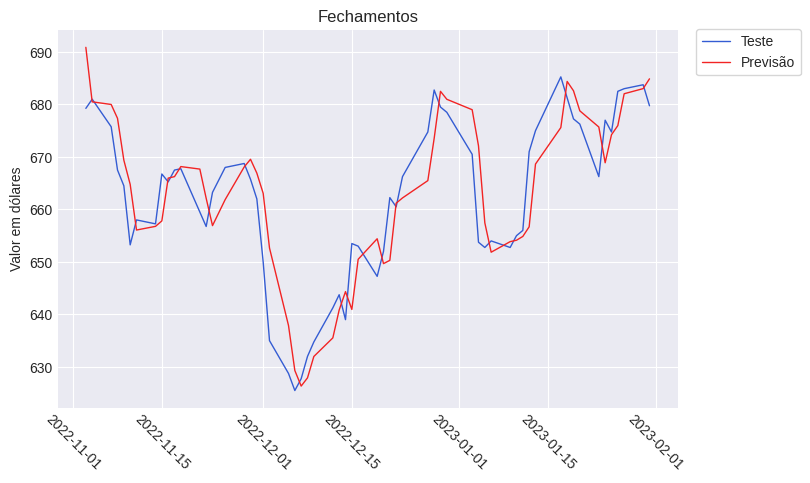

In [79]:
grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=tf.squeeze(horizontes_teste),
               X_previsao=X_test[-len(janelas_teste):], y_previsao=tf.squeeze(previsoes),
               inicio=-60)

In [80]:
metricas[11] = metricas_modelo(tf.squeeze(horizontes_teste), tf.squeeze(previsoes))

## Modelo 12: TensorFlow Ensemble

In [81]:
%%time

conjunto_modelos = obter_modelos(horizonte=horizonte_tamanho,
                                 dados_treino=dataset_treino,
                                 dados_teste=dataset_teste,
                                 modelos_por_perda=5)

Treinando modelo conjunto_modelo_0_perda_mae com 1000 iterações.
Treinando modelo conjunto_modelo_0_perda_mse com 1000 iterações.
Treinando modelo conjunto_modelo_0_perda_mape com 1000 iterações.
Treinando modelo conjunto_modelo_1_perda_mae com 1000 iterações.
Treinando modelo conjunto_modelo_1_perda_mse com 1000 iterações.
Treinando modelo conjunto_modelo_1_perda_mape com 1000 iterações.
Treinando modelo conjunto_modelo_2_perda_mae com 1000 iterações.
Treinando modelo conjunto_modelo_2_perda_mse com 1000 iterações.
Treinando modelo conjunto_modelo_2_perda_mape com 1000 iterações.
Treinando modelo conjunto_modelo_3_perda_mae com 1000 iterações.
Treinando modelo conjunto_modelo_3_perda_mse com 1000 iterações.
Treinando modelo conjunto_modelo_3_perda_mape com 1000 iterações.
Treinando modelo conjunto_modelo_4_perda_mae com 1000 iterações.
Treinando modelo conjunto_modelo_4_perda_mse com 1000 iterações.
Treinando modelo conjunto_modelo_4_perda_mape com 1000 iterações.
CPU times: user 8min

In [82]:
conjunto_previsoes = obter_previsoes(modelos=conjunto_modelos,
                                     dados_teste=dataset_teste)

conjunto_previsoes_media     = tf.reduce_mean(conjunto_previsoes, axis=0)
conjunto_previsoes_desvio    = tf.math.reduce_std(conjunto_previsoes, axis=0)
conjunto_previsoes_intervalo = conjunto_previsoes_desvio * 1.96
conjunto_previsoes_superior  = conjunto_previsoes_media + conjunto_previsoes_intervalo
conjunto_previsoes_inferior  = conjunto_previsoes_media - conjunto_previsoes_intervalo

Prevendo com modelo conjunto_modelo_0_perda_mae.
2/2 [==============================] - 0s 4ms/step
Prevendo com modelo conjunto_modelo_0_perda_mse.
2/2 [==============================] - 0s 5ms/step
Prevendo com modelo conjunto_modelo_0_perda_mape.


2/2 [==============================] - 0s 6ms/step


Prevendo com modelo conjunto_modelo_1_perda_mae.
2/2 [==============================] - 0s 6ms/step
Prevendo com modelo conjunto_modelo_1_perda_mse.
2/2 [==============================] - 0s 4ms/step
Prevendo com modelo conjunto_modelo_1_perda_mape.
2/2 [==============================] - 0s 5ms/step
Prevendo com modelo conjunto_modelo_2_perda_mae.
2/2 [==============================] - 0s 9ms/step
Prevendo com modelo conjunto_modelo_2_perda_mse.
2/2 [==============================] - 0s 5ms/step
Prevendo com modelo conjunto_modelo_2_perda_mape.
2/2 [==============================] - 0s 5ms/step
Prevendo com modelo conjunto_modelo_3_perda_mae.
2/2 [==============================] - 0s 5ms/step
Prevendo com modelo conjunto_modelo_3_perda_mse.
2/2 [==============================] - 0s 5ms/step
Prevendo com modelo conjunto_modelo_3_perda_mape.
2/2 [==============================] - 0s 5ms/step
Prevendo com modelo conjunto_modelo_4_perda_mae.
2/2 [==============================] - 0s 5ms/st

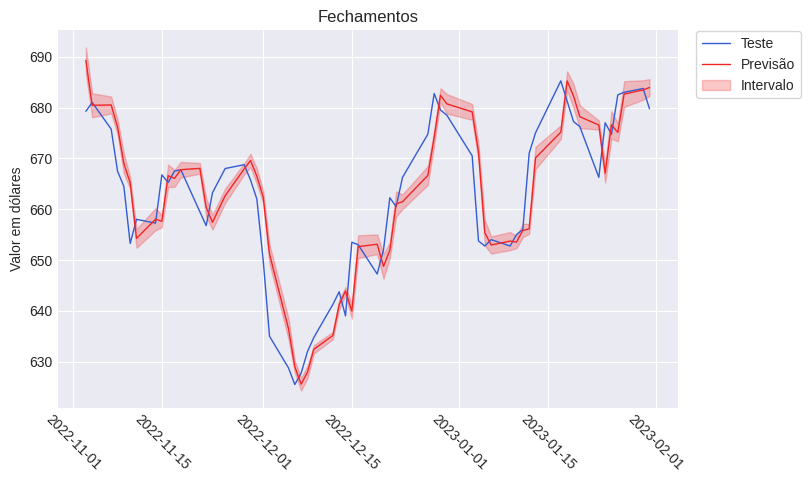

In [83]:
grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=tf.squeeze(horizontes_teste),
               X_previsao=X_test[-len(janelas_teste):], y_previsao=tf.squeeze(conjunto_previsoes_media),
               superior=conjunto_previsoes_superior, inferior=conjunto_previsoes_inferior,
               inicio=-60)

In [84]:
metricas[12] = metricas_modelo(tf.squeeze(horizontes_teste), tf.squeeze(conjunto_previsoes_media))

# Comparação dos modelos

Como as métricas de regressão são medidas de erro, quanto **menor** o valor, melhor o índice.

In [85]:
df_metricas = pd.DataFrame([m for m in metricas if m is not None])
df_metricas.T

,0,1,2,3,4,5,6,7,8,9,10,11,12
Mean Absolute Error,9.159116,9.422266,114.400583,26.892554,11.189703,10.103074,10.541167,11.120134,11.309046,12.267808,9.448688,9.220716,9.156133
Root Mean Squared Error,13.792207,13.918367,144.262265,38.965233,15.979699,15.256096,15.975304,16.780628,17.123238,18.354067,14.509604,14.041435,13.924613
Mean Absolute Percentage Error,0.014169,0.014548,0.163830,0.038268,0.017301,0.015681,0.016386,0.017265,0.017590,0.019038,0.014669,0.014292,0.014186
Mean Absolute Scaled Error,0.998464,1.027151,12.471163,2.931641,1.219824,1.101367,1.149125,1.212240,1.232834,1.337352,1.030031,1.005179,0.998138


In [86]:
df_metricas['Mean Absolute Error'].sort_values()

12      9.156133
0       9.159116
11      9.220716
1       9.422266
10      9.448688
5      10.103074
6      10.541167
7      11.120134
4      11.189703
8      11.309046
9      12.267808
3      26.892554
2     114.400583
Name: Mean Absolute Error, dtype: float64

In [87]:
# for titulo in metricas[0].keys():
#     grafico_metrica([m[titulo] for m in metricas if m is not None], titulo)